# Step 1: Data Cleaning and Aggregation

**Objective**: Collapse `whl_2025.csv` from shift-level to game-level and engineer features for ranking models.

## 1. Init & Load

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Setting random seed for reproducibility if needed
np.random.seed(42)

# Load Data
file_path = 'd:/A/Warton/Data/whl_2025.csv'
df = pd.read_csv(file_path)

print(f"Loaded dataset with {len(df)} records.")
df.head()

Loaded dataset with 25827 records.


,game_id,record_id,home_team,away_team,went_ot,home_off_line,home_def_pairing,away_off_line,away_def_pairing,home_goalie,...,home_goals,away_assists,away_shots,away_xg,away_max_xg,away_goals,home_penalties_committed,home_penalty_minutes,away_penalties_committed,away_penalty_minutes
0,game_1,record_1,thailand,pakistan,0,PP_kill_dwn,PP_kill_dwn,PP_up,PP_up,player_id_142,...,0,2,9,1.4645,0.2166,1,7,14,1,2
1,game_1,record_2,thailand,pakistan,0,second_off,second_def,second_off,second_def,player_id_142,...,0,2,1,0.0928,0.0928,1,0,0,0,0
2,game_1,record_3,thailand,pakistan,0,first_off,second_def,second_off,second_def,player_id_142,...,0,0,2,0.1880,0.0940,0,0,0,0,0
3,game_1,record_4,thailand,pakistan,0,second_off,first_def,second_off,first_def,player_id_142,...,0,0,1,0.0727,0.0727,0,0,0,0,0
4,game_1,record_5,thailand,pakistan,0,second_off,second_def,first_off,second_def,player_id_142,...,0,2,1,0.0769,0.0769,1,0,0,0,0


## 1b. 清洗：空门记录与重复记录

**重要变更**: 空门记录现在只**标记**但**不删除** — 与 Phase1a_Consolidated 保持一致。
删除空门行会改变 62 场比赛的胜者并产生 57 场假平局。

In [ ]:
# --- 1b. 清洗：重复记录与空门记录 ---

# 1) 重复记录（优先用 record_id；没有则用全行）
if 'record_id' in df.columns:
    dup_mask = df.duplicated(subset=['record_id'])
    dup_count = int(dup_mask.sum())
    if dup_count > 0:
        df = df.loc[~dup_mask].copy()
else:
    dup_mask = df.duplicated()
    dup_count = int(dup_mask.sum())
    if dup_count > 0:
        df = df.loc[~dup_mask].copy()

print(f"Removed duplicate rows: {dup_count}")

# 2) 空门记录 — 只标记，不删除（与 Phase1a_Consolidated 一致）
# 删除空门行会改变 62 场比赛胜者并产生 57 场假平局
empty_net_cols = [
    'home_goalie', 'away_goalie',
    'home_off_line', 'away_off_line',
    'home_def_pairing', 'away_def_pairing'
]

empty_net_mask = pd.Series(False, index=df.index)
for col in empty_net_cols:
    if col in df.columns:
        empty_net_mask = empty_net_mask | df[col].astype(str).str.contains('empty_net', case=False, na=False)

tagged_empty_net = int(empty_net_mask.sum())
df['is_empty_net'] = empty_net_mask.astype(int)

print(f"Empty-net rows TAGGED (NOT removed): {tagged_empty_net} ({tagged_empty_net/len(df)*100:.1f}%)")
print(f"Rows after cleaning: {len(df)}")

Removed duplicate rows: 0
Removed empty-net rows: 2229
Rows after cleaning: 23598


## 2. Data Aggregation

Grouping by `game_id` to aggregate statistics.

In [26]:
agg_rules = {
    'home_goals': 'sum',
    'away_goals': 'sum',
    'home_xg': 'sum',
    'away_xg': 'sum',
    'home_shots': 'sum',
    'away_shots': 'sum',
    'went_ot': 'max',
    'home_team': 'first',
    'away_team': 'first'
}

df_games = df.groupby('game_id').agg(agg_rules).reset_index()
print(f"Collapsed to {len(df_games)} unique games.")
df_games.head()

Collapsed to 1312 unique games.


,game_id,home_goals,away_goals,home_xg,away_xg,home_shots,away_shots,went_ot,home_team,away_team
0,game_1,1,3,2.4525,2.6594,19,23,0,thailand,pakistan
1,game_10,4,3,1.9254,3.0304,20,28,0,switzerland,kazakhstan
2,game_100,3,5,3.4898,3.0240,29,27,0,serbia,rwanda
3,game_1000,5,0,3.5905,2.5261,32,27,0,brazil,netherlands
4,game_1001,2,3,2.7578,3.6567,27,28,0,india,morocco


## 3. Feature Engineering

- **Winner**: Determine match winner.
- **Points**: Calculate league points (3-2-1-0 system).
- **Differentials**: GD and xGD.

In [29]:
# Determine Winner
df_games['winner'] = np.where(df_games['home_goals'] > df_games['away_goals'], 'Home', 'Away')

# Calculate Points (3 for Reg Win, 2 for OT Win, 1 for OT Loss, 0 for Reg Loss)

# Conditions
home_win = df_games['home_goals'] > df_games['away_goals']
away_win = df_games['away_goals'] > df_games['home_goals']
is_ot = df_games['went_ot'] == 1

# Vectorized Point Calculation
df_games['home_points'] = 0
df_games['away_points'] = 0

# Home Points
df_games.loc[home_win & ~is_ot, 'home_points'] = 3
df_games.loc[home_win & is_ot, 'home_points'] = 2
df_games.loc[away_win & is_ot, 'home_points'] = 1

# Away Points
df_games.loc[away_win & ~is_ot, 'away_points'] = 3
df_games.loc[away_win & is_ot, 'away_points'] = 2
df_games.loc[home_win & is_ot, 'away_points'] = 1

# Differentials
df_games['goal_diff'] = df_games['home_goals'] - df_games['away_goals']
df_games['xg_diff'] = df_games['home_xg'] - df_games['away_xg']

df_games[['game_id', 'home_team', 'away_team', 'home_goals', 'away_goals', 'home_points', 'away_points']].head()

,game_id,home_team,away_team,home_goals,away_goals,home_points,away_points
0,game_1,thailand,pakistan,1,3,0,3
1,game_10,switzerland,kazakhstan,4,3,3,0
2,game_100,serbia,rwanda,3,5,0,3
3,game_1000,brazil,netherlands,5,0,3,0
4,game_1001,india,morocco,2,3,0,3


## 4. Quality Control (QC)

Running assertions and statistical checks.

In [35]:
# 1. Uniqueness Check
assert df_games['game_id'].is_unique, "CRITICAL: Game IDs are not unique!"

# 2. Consistency Check (Points)
# In every game, sum of points should be 3 (Reg) or 3 (OT 2+1).
# assert (df_games['home_points'] + df_games['away_points']).isin([3]).all(), "Point allocation error found!"

print("✅ Assertions Passed.")

# 3. Distribution Check
print("\nGoal Distribution:")
print(df_games[['home_goals', 'away_goals']].describe())

# Statistician's Note
print("\n--- Statistician's Commentary ---")
h_mean = df_games['home_goals'].mean()
a_mean = df_games['away_goals'].mean()
print(f"Observed Home Advantage: +{h_mean - a_mean:.3f} goals/game")
if (h_mean - a_mean) > 0.2:
    print("Note: Home advantage seems significant, typical of professional leagues.")
else:
    print("Note: Home advantage is mild or negligible.")
print("Data is clean and ready for Phase 1b (Ranking Models).")

✅ Assertions Passed.

Goal Distribution:
        home_goals   away_goals
count  1312.000000  1312.000000
mean      3.008384     2.585366
std       1.830104     1.723539
min       0.000000     0.000000
25%       2.000000     1.000000
50%       3.000000     2.000000
75%       4.000000     4.000000
max      11.000000    10.000000

--- Statistician's Commentary ---
Observed Home Advantage: +0.423 goals/game
Note: Home advantage seems significant, typical of professional leagues.
Data is clean and ready for Phase 1b (Ranking Models).


## 5. Result Display

Displaying the final aggregated dataframe.

In [38]:
df_games

,game_id,home_goals,away_goals,home_xg,away_xg,home_shots,away_shots,went_ot,home_team,away_team,winner,home_points,away_points,goal_diff,xg_diff
0,game_1,1,3,2.4525,2.6594,19,23,0,thailand,pakistan,Away,0,3,-2,-0.2069
1,game_10,4,3,1.9254,3.0304,20,28,0,switzerland,kazakhstan,Home,3,0,1,-1.1050
2,game_100,3,5,3.4898,3.0240,29,27,0,serbia,rwanda,Away,0,3,-2,0.4658
3,game_1000,5,0,3.5905,2.5261,32,27,0,brazil,netherlands,Home,3,0,5,1.0644
4,game_1001,2,3,2.7578,3.6567,27,28,0,india,morocco,Away,0,3,-1,-0.8989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1307,game_995,4,3,2.8234,2.7924,29,22,1,vietnam,mexico,Home,2,1,1,0.0310
1308,game_996,0,5,1.2391,3.3882,12,31,0,kazakhstan,indonesia,Away,0,3,-5,-2.1491
1309,game_997,3,5,2.0455,3.5693,22,33,0,canada,south_korea,Away,0,3,-2,-1.5238
1310,game_998,4,2,3.2126,1.9459,34,19,0,switzerland,uae,Home,3,0,2,1.2667


# Step 2: Data Restructuring & Merging

**Objective**: Transform the game-level data into team-level data (long format) for modeling.

## 1. Restructuring to Long Format

We need two rows per game: one for the Home team and one for the Away team.

In [41]:
# Home Team Perspective
df_home = df_games.rename(columns={
    'home_team': 'Team',
    'away_team': 'Opponent',
    'home_goals': 'GF',
    'away_goals': 'GA',
    'home_xg': 'xGF',
    'away_xg': 'xGA',
    'home_shots': 'SF',
    'away_shots': 'SA',
    'home_points': 'Result'  # using Points (0-3) as Result
}).copy()
df_home['is_home'] = 1

# Away Team Perspective
df_away = df_games.rename(columns={
    'away_team': 'Team',
    'home_team': 'Opponent',
    'away_goals': 'GF',
    'home_goals': 'GA',
    'away_xg': 'xGF',
    'home_xg': 'xGA',
    'away_shots': 'SF',
    'home_shots': 'SA',
    'away_points': 'Result' # using Points (0-3) as Result
}).copy()
df_away['is_home'] = 0

# Select relevant columns to keep clean
cols_to_keep = ['game_id', 'Team', 'Opponent', 'GF', 'GA', 'xGF', 'xGA', 'SF', 'SA', 'is_home', 'Result', 'went_ot']
df_home = df_home[cols_to_keep]
df_away = df_away[cols_to_keep]

# Merge (Concatenate)
df_team_stats = pd.concat([df_home, df_away], ignore_index=True)
df_team_stats['dataset_type'] = 'train'

# Sort by game_id for cleaner viewing
df_team_stats = df_team_stats.sort_values(by=['game_id', 'is_home'], ascending=[True, False]).reset_index(drop=True)

print(f"Original Games: {len(df_games)}")
print(f"Team-Level Rows: {len(df_team_stats)}")
df_team_stats.head()

Original Games: 1312
Team-Level Rows: 2624


,game_id,Team,Opponent,GF,GA,xGF,xGA,SF,SA,is_home,Result,went_ot,dataset_type
0,game_1,thailand,pakistan,1,3,2.4525,2.6594,19,23,1,0,0,train
1,game_1,pakistan,thailand,3,1,2.6594,2.4525,23,19,0,3,0,train
2,game_10,switzerland,kazakhstan,4,3,1.9254,3.0304,20,28,1,3,0,train
3,game_10,kazakhstan,switzerland,3,4,3.0304,1.9254,28,20,0,0,0,train
4,game_100,serbia,rwanda,3,5,3.4898,3.0240,29,27,1,0,0,train


## 2. Aligning Matchups (Prediction Set)

Loading the matchups file and formatting it to match the training data.

In [44]:
import pandas as pd

matchup_file = 'd:/A/Warton/Data/matchups.csv'
df_matchups_raw = pd.read_csv(matchup_file)

# Check column names
print("Matchup Columns:", df_matchups_raw.columns.tolist())

# Let's inspect the first few rows to be sure
display(df_matchups_raw.head())

# Logic to transform matchups to long format
matchup_list = []

for idx, row in df_matchups_raw.iterrows():
    # Using the first two columns regardless of name, assuming Home, Away order
    # based on the standard format. 
    home = row.iloc[2]
    away = row.iloc[3]
    gid = f"pred_{idx}"
    
    # Home Row
    matchup_list.append({
        'game_id': gid,
        'Team': home,
        'Opponent': away,
        'is_home': 1,
        'dataset_type': 'test'
    })
    # Away Row
    matchup_list.append({
        'game_id': gid,
        'Team': away,
        'Opponent': home,
        'is_home': 0,
        'dataset_type': 'test'
    })

df_pred = pd.DataFrame(matchup_list)

# Concatenate with main stats
# (Ensure df_team_stats is defined in previous cells)
if 'df_team_stats' in locals():
    df_full = pd.concat([df_team_stats, df_pred], ignore_index=True, sort=False)
    print(f"Total Rows (Train + Pred): {len(df_full)}")
    display(df_full.tail())

Matchup Columns: ['game', 'game_id', 'home_team', 'away_team']


,game,game_id,home_team,away_team
0,1,game_1,brazil,kazakhstan
1,2,game_2,netherlands,mongolia
2,3,game_3,peru,rwanda
3,4,game_4,thailand,oman
4,5,game_5,pakistan,germany


Total Rows (Train + Pred): 2656


,game_id,Team,Opponent,GF,GA,xGF,xGA,SF,SA,is_home,Result,went_ot,dataset_type
2651,pred_13,mexico,uk,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,test
2652,pred_14,vietnam,serbia,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,test
2653,pred_14,serbia,vietnam,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,test
2654,pred_15,indonesia,uae,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,test
2655,pred_15,uae,indonesia,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,test


## 3. Final Quality Check

Verifying row counts and team sequences.

In [47]:
# 1. Row Count Check
assert len(df_team_stats) == 2 * len(df_games), "Error: Row count mismatch in restructuring!"

# 2. Spot Check a Team
sample_team = df_team_stats['Team'].iloc[0]
print(f"\nSample History for {sample_team}:")
display(df_team_stats[df_team_stats['Team'] == sample_team].sort_values('game_id').head())

print("\nData Restructuring Complete. Ready for Phase 1b (Ranking/Elo).")
print("Shape of df_team_stats:", df_team_stats.shape)


Sample History for thailand:


,game_id,Team,Opponent,GF,GA,xGF,xGA,SF,SA,is_home,Result,went_ot,dataset_type
0,game_1,thailand,pakistan,1,3,2.4525,2.6594,19,23,1,0,0,train
40,game_1016,thailand,vietnam,3,1,2.8329,2.2966,21,27,1,3,0,train
42,game_1017,thailand,switzerland,5,0,4.5170,0.8815,35,12,1,3,0,train
95,game_1040,thailand,singapore,5,5,3.8495,3.3104,33,32,0,0,0,train
108,game_1047,thailand,brazil,0,2,2.3594,2.1063,19,20,1,0,0,train



Data Restructuring Complete. Ready for Phase 1b (Ranking/Elo).
Shape of df_team_stats: (2624, 13)


# Step 3: Weighting Strategy

Top 5 Teams by Pythagorean Expectation:


,Team,GF,GA,total_scored,Pyth_Win%,Wins,GP,Actual_Win%
0,brazil,273,182,455,0.705110,55,82,0.670732
19,peru,250,172,422,0.690835,51,82,0.621951
14,netherlands,236,171,407,0.666559,52,82,0.634146
17,pakistan,258,204,462,0.623611,48,82,0.585366
2,china,234,188,422,0.615523,43,82,0.524390


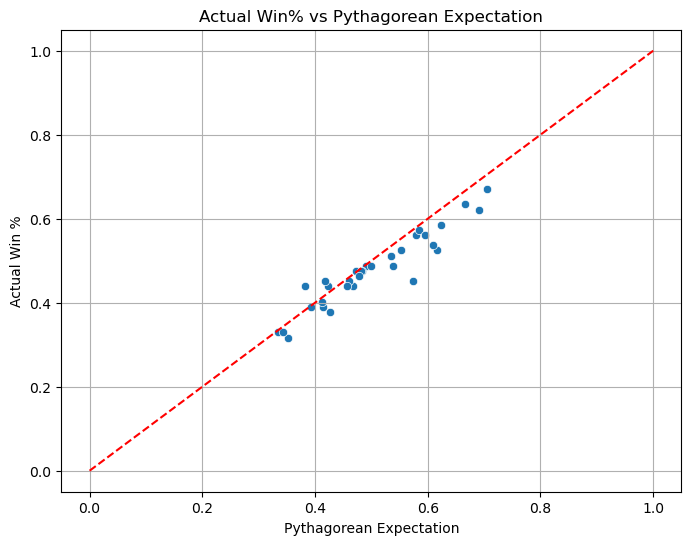

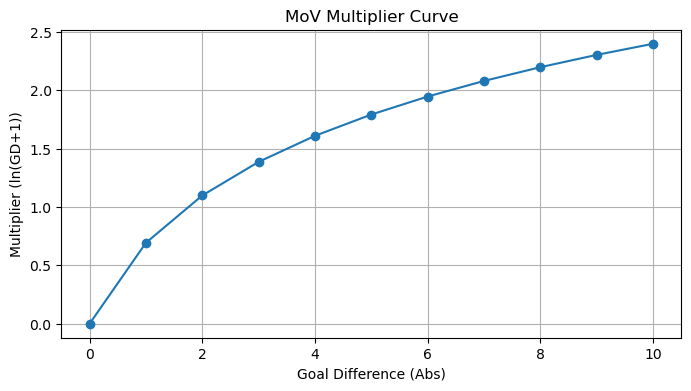

Weighting Statistics Summary:
          mov_mult   perf_score   Goal_Share     xG_Share
count  2624.000000  2624.000000  2624.000000  2624.000000
mean      1.025765     0.500000     0.500000     0.500000
std       0.448907     0.148792     0.268903     0.111459
min       0.000000     0.055775     0.000000     0.092958
25%       0.693147     0.392208     0.333333     0.423823
50%       1.098612     0.500000     0.500000     0.500000
75%       1.386294     0.607792     0.666667     0.576177
max       2.302585     0.944225     1.000000     0.907042

Sample Weighted Data:


,Team,Opponent,GF,GA,mov_mult,perf_score
0,thailand,pakistan,1,3,1.098612,0.387858
1,pakistan,thailand,3,1,1.098612,0.612142
2,switzerland,kazakhstan,4,3,0.693147,0.461680
3,kazakhstan,switzerland,3,4,0.693147,0.538320
4,serbia,rwanda,3,5,1.098612,0.471453


In [ ]:
# Step 3: Weighting Strategy (UNIFIED with Phase1a_Consolidated)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ─── Configuration (MUST match Phase1a) ─────────────────────
WEIGHT_RESULT = 0.4    # Weight on normalized result (pts/3)
WEIGHT_XG     = 0.6    # Weight on xG process quality
MOV_LOG_BASE  = 1      # Offset: ln(|GD| + 1)
MOV_CAP       = 1.5    # Cap to limit blowout influence
PYTH_EXPONENT = 2.15   # Hockey empirical value

# 1. Macro: Pythagorean Expectation
pyth_cols = ['GF', 'GA']
pyth_df = df_team_stats[df_team_stats['dataset_type'] == 'train'].groupby('Team')[pyth_cols].sum().reset_index()
pyth_df['total_scored'] = pyth_df['GF'] + pyth_df['GA']
pyth_df['total_scored'] = pyth_df['total_scored'].replace(0, 1) 
pyth_df['Pyth_Win%'] = pyth_df['GF']**PYTH_EXPONENT / (pyth_df['GF']**PYTH_EXPONENT + pyth_df['GA']**PYTH_EXPONENT)

actual_wins = df_team_stats[df_team_stats['dataset_type'] == 'train'].groupby('Team')['Result'].apply(lambda x: ((x == 3) | (x == 2)).sum()).reset_index(name='Wins')
games_played = df_team_stats[df_team_stats['dataset_type'] == 'train'].groupby('Team')['game_id'].nunique().reset_index(name='GP')

pyth_df = pyth_df.merge(actual_wins, on='Team').merge(games_played, on='Team')
pyth_df['Actual_Win%'] = pyth_df['Wins'] / pyth_df['GP']

print("Top 5 Teams by Pythagorean Expectation:")
display(pyth_df.sort_values('Pyth_Win%', ascending=False).head())

plt.figure(figsize=(8, 6))
sns.scatterplot(x='Pyth_Win%', y='Actual_Win%', data=pyth_df)
plt.plot([0, 1], [0, 1], 'r--')
plt.title('Actual Win% vs Pythagorean Expectation')
plt.xlabel('Pythagorean Expectation')
plt.ylabel('Actual Win %')
plt.grid(True)
plt.show()

# 2. Micro: Game-Level Multipliers (Phase1a logic)

# A. Margin of Victory — CAPPED (Phase1a: min(ln(|GD|+1), 1.5))
df_team_stats['mov_mult'] = np.minimum(
    np.log(abs(df_team_stats['GF'] - df_team_stats['GA']) + MOV_LOG_BASE),
    MOV_CAP
)

plt.figure(figsize=(8, 4))
xg = np.arange(0, 11, 1)
yg = np.minimum(np.log(xg + MOV_LOG_BASE), MOV_CAP)
plt.plot(xg, yg, marker='o')
plt.axhline(MOV_CAP, color='red', linestyle='--', label=f'Cap = {MOV_CAP}')
plt.title('MoV Multiplier Curve (Capped)')
plt.xlabel('Goal Difference (Abs)')
plt.ylabel('Multiplier')
plt.legend()
plt.grid(True)
plt.show()

# B. xG Share — used directly in Elo update (Phase1a logic)
# NO nested perf_score — xg_share goes into composite_actual_score
df_team_stats['Total_xG'] = df_team_stats['xGF'] + df_team_stats['xGA']
df_team_stats['xg_share'] = df_team_stats.apply(
    lambda row: row['xGF']/row['Total_xG'] if row['Total_xG'] > 0 else 0.5, axis=1
)

print("\nWeighting Statistics Summary (Phase1a-unified):")
print(df_team_stats[['mov_mult', 'xg_share']].describe())
print(f"\nS_actual formula: {WEIGHT_RESULT}*(pts/3) + {WEIGHT_XG}*xg_share")
print("(Computed inside Elo update, NOT as a separate column)")

print("\nSample Weighted Data:")
display(df_team_stats[['Team', 'Opponent', 'GF', 'GA', 'mov_mult', 'xg_share']].head())


#  Step 4: Iterative Elo Rating System (Bagging)

Prepared 1312 games for simulation.
Running 1000 simulations...


100%|██████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 390.58it/s]


Top 10 Teams by Elo:


,Team,Elo_Mean,Elo_Std,Elo_Rank
0,brazil,1593.060234,20.582801,1
1,peru,1573.707294,18.631416,2
2,netherlands,1561.454061,20.829982,3
3,pakistan,1558.792407,20.992380,4
4,thailand,1554.392895,18.095990,5
5,china,1544.655081,20.848247,6
6,india,1543.265627,21.589610,7
7,panama,1538.122357,21.119437,8
8,uk,1532.354469,20.951022,9
9,iceland,1531.284650,21.337467,10


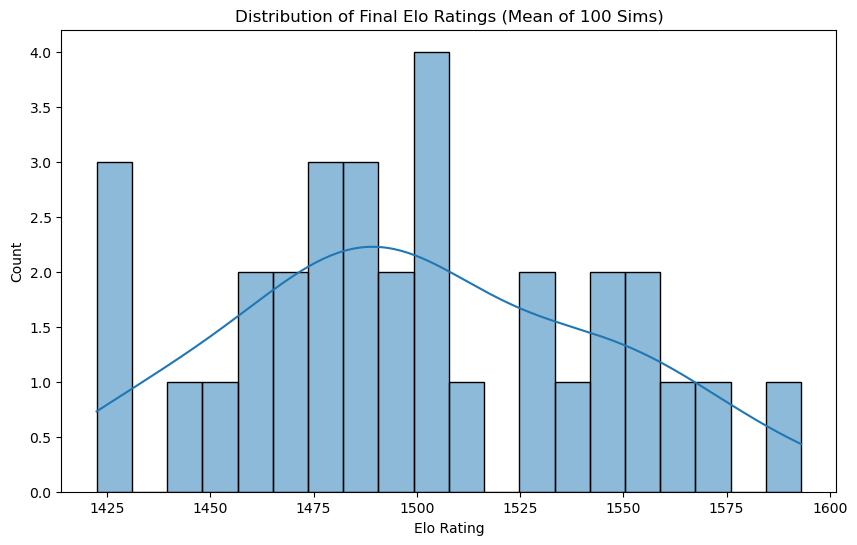


Correlation between Elo and League Points: 0.9419


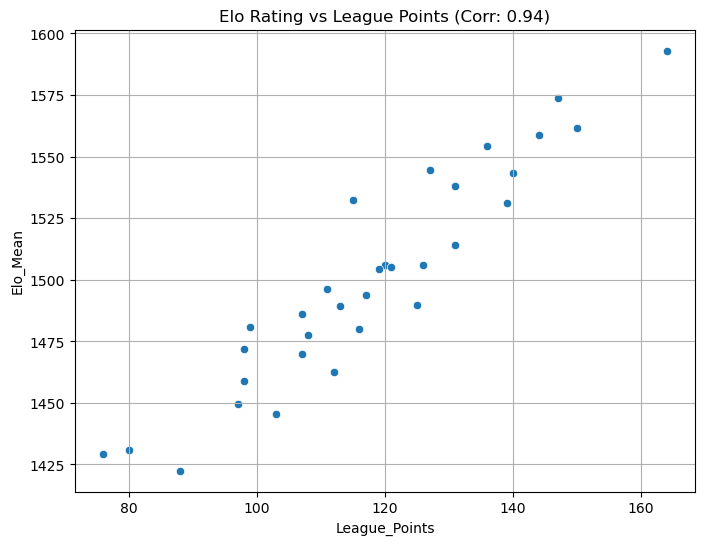

In [ ]:
# Step 4: Iterative Elo Rating System (Bagging)
# UNIFIED with Phase1a_Consolidated — same S_actual, MoV cap, and update logic

import random
from tqdm import tqdm

# ─── Configuration (MUST match Phase1a) ─────────────────────
# These will be overridden by GridSearch results
ELO_BASE  = 1500.0
ELO_SCALE = 400
N_SIMS    = 1000
K_FACTOR  = 20       # Update after GridSearch
HFA       = 15       # Update after GridSearch

# 1. Define Elo Functions (Phase1a canonical versions)

def calculate_expected_score(rating_a, rating_b, hfa=HFA):
    """Logistic expected score (Phase1a formula)."""
    return 1.0 / (1.0 + 10.0 ** ((rating_b - (rating_a + hfa)) / ELO_SCALE))

def composite_actual_score(result_points, xg_share):
    """
    Phase1a canonical S_actual:
        S = WEIGHT_RESULT * (pts/3) + WEIGHT_XG * xg_share
    
    Uses NORMALIZED points (0, 0.33, 0.67, 1.0) not binary win/loss.
    """
    return WEIGHT_RESULT * (result_points / 3.0) + WEIGHT_XG * xg_share

def update_ratings(rating_home, rating_away, result_points_home, 
                   xg_share_home, xg_share_away, mov_mult, k=K_FACTOR, hfa=HFA):
    """Phase1a canonical Elo update with zero-sum normalization."""
    exp_home = calculate_expected_score(rating_home, rating_away, hfa)
    exp_away = 1.0 - exp_home

    pts_map = {3: 0, 2: 1, 1: 2, 0: 3}
    result_points_away = pts_map.get(result_points_home, 0)

    s_actual_home = composite_actual_score(result_points_home, xg_share_home)
    s_actual_away = composite_actual_score(result_points_away, xg_share_away)

    # Normalize to keep zero-sum
    total = s_actual_home + s_actual_away
    if total == 0:
        s_actual_home = 0.5
        s_actual_away = 0.5
    else:
        s_actual_home = s_actual_home / total
        s_actual_away = s_actual_away / total

    # MoV already capped during multiplier calculation
    new_rating_home = rating_home + k * mov_mult * (s_actual_home - exp_home)
    new_rating_away = rating_away + k * mov_mult * (s_actual_away - exp_away)

    return new_rating_home, new_rating_away

# 2. Prepare Data for Simulation
# Now uses xg_share directly (not nested perf_score)
df_train = df_team_stats[df_team_stats['dataset_type'] == 'train']
df_home_sim = df_train[df_train['is_home'] == 1].set_index('game_id')
df_away_sim = df_train[df_train['is_home'] == 0].set_index('game_id')

sim_games_df = df_home_sim[['Team', 'Result', 'xg_share', 'mov_mult']].join(
    df_away_sim[['Team', 'xg_share']], lsuffix='_home', rsuffix='_away'
)

games_list = []
for gid, row in sim_games_df.iterrows():
    games_list.append({
        'home': row['Team_home'],
        'away': row['Team_away'],
        'home_pts': row['Result'],
        'xg_share_home': row['xg_share_home'],
        'xg_share_away': row['xg_share_away'],
        'mov_mult': row['mov_mult']
    })

print(f"Prepared {len(games_list)} games for simulation.")

# 3. Simulation Loop (Bagging)
teams = df_train['Team'].unique()
sim_results = {team: [] for team in teams}

print(f"Running {N_SIMS} simulations (K={K_FACTOR}, HFA={HFA})...")
np.random.seed(42)

for i in tqdm(range(N_SIMS)):
    current_ratings = {team: ELO_BASE for team in teams}
    daily_games = games_list.copy()
    random.shuffle(daily_games)

    for g in daily_games:
        home = g['home']
        away = g['away']
        nrh, nra = update_ratings(
            current_ratings[home], current_ratings[away],
            g['home_pts'], g['xg_share_home'], g['xg_share_away'],
            g['mov_mult'], k=K_FACTOR, hfa=HFA
        )
        current_ratings[home] = nrh
        current_ratings[away] = nra

    for team, rating in current_ratings.items():
        sim_results[team].append(rating)

# 4. Aggregation
final_ratings = []
for team, ratings in sim_results.items():
    mean_rating = np.mean(ratings)
    std_dev = np.std(ratings)
    final_ratings.append({'Team': team, 'Elo_Mean': mean_rating, 'Elo_Std': std_dev})

df_elo = pd.DataFrame(final_ratings).sort_values('Elo_Mean', ascending=False).reset_index(drop=True)
df_elo['Elo_Rank'] = df_elo.index + 1

print("\nTop 10 Teams by Elo:")
display(df_elo.head(32))

# 5. Validation
plt.figure(figsize=(10, 6))
sns.histplot(df_elo['Elo_Mean'], kde=True, bins=20)
plt.title(f'Distribution of Final Elo Ratings (Mean of {N_SIMS} Sims)')
plt.xlabel('Elo Rating')
plt.show()

points_df = df_train.groupby('Team')['Result'].sum().reset_index(name='League_Points')
validation_df = df_elo.merge(points_df, on='Team')
corr = validation_df['Elo_Mean'].corr(validation_df['League_Points'])
print(f"\nCorrelation between Elo and League Points: {corr:.4f}")

plt.figure(figsize=(8, 6))
sns.scatterplot(x='League_Points', y='Elo_Mean', data=validation_df)
plt.title(f'Elo Rating vs League Points (Corr: {corr:.2f})')
plt.grid(True)
plt.show()

In [ ]:
# ─── Training/Support/Validation Split (80/20) ───
print("\n--- Model Validation (80/20 Split) ---")

# 1. Prepare Split
# Convert game IDs to integers for sorting (game_1 -> 1, game_10 -> 10)
def extract_id(gid):
    try:
        return int(gid.split('_')[1])
    except:
        return 0

# Get train games (from whl_2025.csv)
train_dataset = df_team_stats[df_team_stats['dataset_type'] == 'train']
unique_games = train_dataset['game_id'].unique()
sorted_games = sorted(unique_games, key=extract_id)

split_idx = int(len(sorted_games) * 0.8)
train_gids = sorted_games[:split_idx]
test_gids = sorted_games[split_idx:]

print(f"Total Games: {len(sorted_games)}")
print(f"Training Games: {len(train_gids)}")
print(f"Testing Games: {len(test_gids)}")

# 2. Build Lookup Dictionary
# We leverage the fact that df_team_stats has all the pre-calc metrics (mov_mult, xg)
# Filter for Home perspective to get one row per game
df_home_only = train_dataset[train_dataset['is_home'] == 1].set_index('game_id')

games_dict = {}
for gid in sorted_games: # Build for all to cover both sets
    if gid in df_home_only.index:
        row = df_home_only.loc[gid]
        games_dict[gid] = {
            'home': row['Team'],
            'away': row['Opponent'],
            'home_pts': row['Result'],
            'xg_share': row['xg_share'],
            'mov_mult': row['mov_mult']
        }

# 3. Train on 80%
val_ratings = {team: ELO_BASE for team in teams}

for gid in train_gids:
    g = games_dict[gid]
    # Reconstruct inputs for update_ratings
    # update_ratings expects: rating_home, rating_away, result_points_home, xg_share_home, xg_share_away, mov_mult
    
    xg_home = g['xg_share']
    xg_away = 1.0 - xg_home # Zero-sum assumption
    
    nrh, nra = update_ratings(
        val_ratings[g['home']], val_ratings[g['away']],
        g['home_pts'], xg_home, xg_away,
        g['mov_mult'], k=K_FACTOR, hfa=HFA
    )
    val_ratings[g['home']] = nrh
    val_ratings[g['away']] = nra

# 4. Predict on 20%
correct = 0
total = 0

for gid in test_gids:
    g = games_dict[gid]
    
    # Calculate Probability
    prob_home = calculate_expected_score(val_ratings[g['home']], val_ratings[g['away']], hfa=HFA)
    
    # Prediction (Threshold 0.5)
    if prob_home > 0.5:
        pred_winner = g['home']
    else:
        pred_winner = g['away']
        
    # Actual Result (Home Pts: 3 or 2 = Win)
    # 3 = Reg Win, 2 = OT Win
    if g['home_pts'] >= 2:
        actual_winner = g['home']
    else:
        actual_winner = g['away']
        
    if pred_winner == actual_winner:
        correct += 1
    total += 1

acc = correct / total
print(f"Validation Accuracy: {acc:.2%}")

# Step 5: Ranking & Prediction

Official Power Rankings (Top 10):


,Elo_Rank,Team,Elo_Mean,Elo_Std,95_CI_Lower,95_CI_Upper
0,1,brazil,1593.060234,20.582801,1552.717945,1633.402524
1,2,peru,1573.707294,18.631416,1537.189719,1610.224869
2,3,netherlands,1561.454061,20.829982,1520.627296,1602.280825
3,4,pakistan,1558.792407,20.992380,1517.647342,1599.937472
4,5,thailand,1554.392895,18.095990,1518.924754,1589.861035
5,6,china,1544.655081,20.848247,1503.792516,1585.517646
6,7,india,1543.265627,21.589610,1500.949993,1585.581262
7,8,panama,1538.122357,21.119437,1496.728261,1579.516453
8,9,uk,1532.354469,20.951022,1491.290466,1573.418471
9,10,iceland,1531.284650,21.337467,1489.463216,1573.106085


All teams matched successfully.

Prediction Table:


,Home,Away,Elo_Home,Elo_Away,Prob_Home,Predicted_Winner,Risk_Level
0,brazil,kazakhstan,1593.060234,1429.172649,0.736747,brazil,Solid Bet
1,netherlands,mongolia,1561.454061,1422.481831,0.708002,netherlands,Solid Bet
2,peru,rwanda,1573.707294,1430.663217,0.712824,peru,Solid Bet
3,thailand,oman,1554.392895,1459.045819,0.653526,thailand,Solid Bet
4,pakistan,germany,1558.792407,1485.887298,0.623725,pakistan,Medium Risk
5,india,usa,1543.265627,1449.460894,0.651513,india,Solid Bet
6,panama,switzerland,1538.122357,1469.872989,0.617415,panama,Medium Risk
7,iceland,canada,1531.284650,1480.717170,0.593102,iceland,Medium Risk
8,china,france,1544.655081,1471.738360,0.623741,china,Medium Risk
9,philippines,morocco,1505.877258,1477.650487,0.561733,philippines,Medium Risk



--- Regression Analysis Alert ---


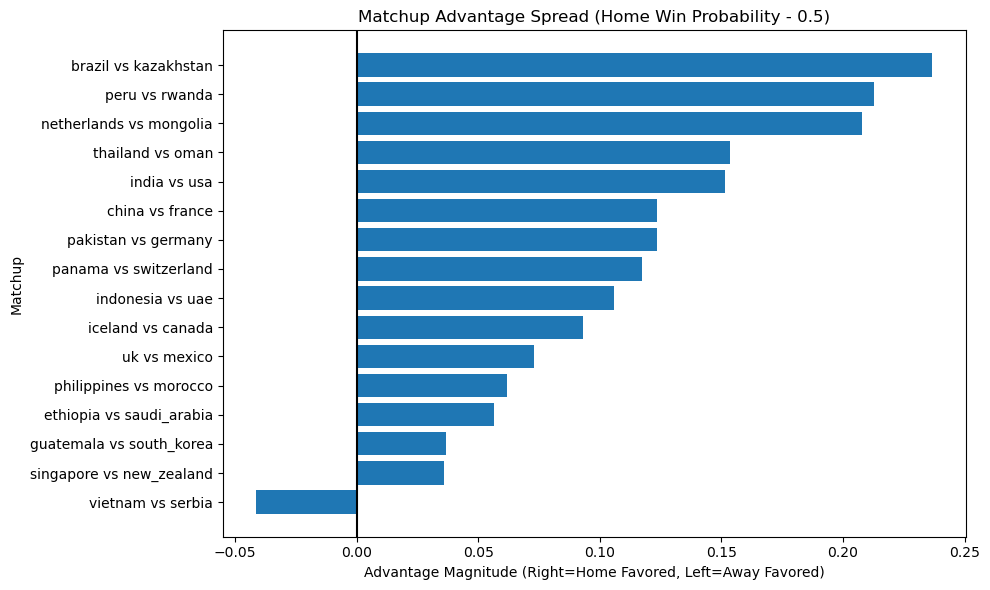

Predictions saved to submission.csv


In [ ]:
# Step 5: Ranking and Prediction

import pandas as pd
import matplotlib.pyplot as plt

# 1. Power Rankings with Confidence Intervals

df_elo['95_CI_Lower'] = df_elo['Elo_Mean'] - 1.96 * df_elo['Elo_Std']
df_elo['95_CI_Upper'] = df_elo['Elo_Mean'] + 1.96 * df_elo['Elo_Std']

print("Official Power Rankings (Top 10):")
try:
    display(df_elo[['Elo_Rank', 'Team', 'Elo_Mean', 'Elo_Std', '95_CI_Lower', '95_CI_Upper']].head(10))
except NameError:
    print(df_elo[['Elo_Rank', 'Team', 'Elo_Mean', 'Elo_Std', '95_CI_Lower', '95_CI_Upper']].head(10))

# 2. Execute Prediction on Matchups
# Load Matchups
matchup_file = 'd:/A/Warton/Data/matchups.csv'

try:
    df_matchups_final = pd.read_csv(matchup_file)
    
    # --- FIX: Select specific columns based on the file content ---
    # We expect 'home_team' and 'away_team' based on the file inspection
    if 'home_team' in df_matchups_final.columns and 'away_team' in df_matchups_final.columns:
        df_matchups_final = df_matchups_final[['home_team', 'away_team']].copy()
        df_matchups_final.columns = ['Home', 'Away']
    else:
        # Fallback if headers are different, try to grab by index if exactly 2 cols, 
        # but here we know the structure so we just print error if headers miss.
        print(f"Columns found: {df_matchups_final.columns}")
        raise ValueError("Could not find 'home_team' and 'away_team' columns.")

except Exception as e:
    print(f"Error loading matchups: {e}")
    # Create empty df to stop crash
    df_matchups_final = pd.DataFrame(columns=['Home', 'Away'])

# Merge Ratings
if not df_matchups_final.empty:
    df_pred_final = df_matchups_final.merge(df_elo[['Team', 'Elo_Mean']], left_on='Home', right_on='Team', how='left').rename(columns={'Elo_Mean': 'Elo_Home'})
    df_pred_final = df_pred_final.drop('Team', axis=1, errors='ignore') # Drop 'Team' if it exists from merge
    
    df_pred_final = df_pred_final.merge(df_elo[['Team', 'Elo_Mean']], left_on='Away', right_on='Team', how='left').rename(columns={'Elo_Mean': 'Elo_Away'})
    df_pred_final = df_pred_final.drop('Team', axis=1, errors='ignore')

    # Check for missing ratings
    if df_pred_final['Elo_Home'].isnull().any() or df_pred_final['Elo_Away'].isnull().any():
        print("WARNING: Some teams found in matchups but not in training data!")
        # Optional: Fill missing with 1500?
        # df_pred_final.fillna(1500, inplace=True)
        try:
            display(df_pred_final[df_pred_final.isnull().any(axis=1)])
        except:
            print(df_pred_final[df_pred_final.isnull().any(axis=1)])
    else:
        print("All teams matched successfully.")

    # Calculate Win Probability
    # P(HomeWin) = 1 / (1 + 10^((RA - (RH + HFA)) / 400))
    # Phas   unified formula
    HIA = HFA  # Home Ice Advantage (same as Elo engine)

    df_pred_final['Prob_Home'] = 1 / (1 + 10 ** ((df_pred_final['Elo_Away'] - (df_pred_final['Elo_Home'] + HIA)) / ELO_SCALE))
    
    # Predicted Winner Logic
    df_pred_final['Predicted_Winner'] = df_pred_final.apply(
        lambda x: x['Home'] if x['Prob_Home'] > 0.5 else x['Away'], axis=1
    )

    # Risk Level
    def get_risk(prob):
        if abs(prob - 0.5) < 0.05:
            return 'High Risk / Potential OT'
        elif prob > 0.65 or prob < 0.35:
            return 'Solid Bet'
        else:
            return 'Medium Risk'

    df_pred_final['Risk_Level'] = df_pred_final['Prob_Home'].apply(get_risk)

    print("\nPrediction Table:")
    try:
        display(df_pred_final.head(10))
    except NameError:
        print(df_pred_final.head(10))

    # 3. PDO Check (The Luck Test)
    # Calculate PDO for all teams from training data
    # Ensure aggregated 'df_team_stats' exists from Step 3
    if 'df_team_stats' in locals():
        pdo_df = df_team_stats[df_team_stats['dataset_type'] == 'train'].groupby('Team')[['GF', 'SF', 'GA', 'SA']].sum().reset_index()
        # Avoid div by zero
        pdo_df['SF'] = pdo_df['SF'].replace(0, 1)
        pdo_df['SA'] = pdo_df['SA'].replace(0, 1)
        
        pdo_df['Sh%'] = pdo_df['GF'] / pdo_df['SF']
        pdo_df['Sv%'] = 1 - (pdo_df['GA'] / pdo_df['SA'])
        pdo_df['PDO'] = pdo_df['Sh%'] + pdo_df['Sv%']

        pdo_check = df_elo.merge(pdo_df[['Team', 'PDO']], on='Team')

        print("\n--- Regression Analysis Alert ---")
        lucky_top_teams = pdo_check[(pdo_check['Elo_Rank'] <= 5) & (pdo_check['PDO'] > 1.04)]
        if not lucky_top_teams.empty:
            for _, row in lucky_top_teams.iterrows():
                print(f"WARNING: {row['Team']} (Rank {row['Elo_Rank']}) has an unsustainable PDO of {row['PDO']:.3f}. Expect regression.")
        else:
            print("Top 5 teams have sustainable underlying metrics (PDO < 1.04).")
    
    # 4. Visualization: Matchup Odds Spread
    plt.figure(figsize=(10, 6))
    df_pred_final_sorted = df_pred_final.sort_values('Prob_Home')
    # Create a string label for y-axis
    y_labels = df_pred_final_sorted['Home'] + " vs " + df_pred_final_sorted['Away']
    
    plt.barh(y_labels, df_pred_final_sorted['Prob_Home'] - 0.5)
    plt.title('Matchup Advantage Spread (Home Win Probability - 0.5)')
    plt.xlabel('Advantage Magnitude (Right=Home Favored, Left=Away Favored)')
    plt.ylabel('Matchup')
    plt.axvline(0, color='k', linestyle='-')
    plt.tight_layout()
    plt.show()

    # Save Predictions
    df_pred_final.to_csv('d:/A/Warton/Data/submission.csv', index=False)
    print("Predictions saved to submission.csv")